# 00 settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats
from scipy import signal
import pymannkendall as mk
from oasis.functions import deconvolve

# settings
burst_time_range = [2310, 2340, 2370, 2420, 2453, 2486, 2554, 2596, 2688, 2713, \
             2766, 2916, 3012, 3072, 3130, 3282, 3402, 3581, 3661]
supp_time_range = [2296, 2330, 2358, 2396, 2439, 2475, 2526, 2656, 2746, 2846,\
             2976, 3036, 3096, 3196, 3256, 3316, 3446, 3616, 3716]

duration = 10
awake_start, awake_end = 100, 1800
recovery_start, recovery_end = 5000, 8000

# path
res_path = 'XXX/data_analysis_res_mXXX/'
load_path = 'XXX/data_mXXX/'

print("res_path:", res_path)
print("load_path:", load_path)

res_path: XXX/data_analysis_res_mXXX/
load_path: XXX/data_mXXX/


# 01 data pre-processing

In [ ]:
# load original data
valid_C = pd.read_csv(load_path + "valid_C.csv")
valid_C = valid_C.values
print("valid_C:", type(valid_C), valid_C.shape)

fig,ax = plt.subplots(figsize=(10,4), dpi=100,facecolor="w")
caxes = ax.matshow(valid_C, vmin = -1.5, vmax = 1.5, cmap = "viridis", aspect = "auto")
fig.colorbar(caxes)
plt.title("whole brain original")
plt.show()

# highpass filter
freq = 0.005
fs = 10
f = 2 * freq / fs
b, a = signal.butter(4, f, "highpass")

neurons_rec_whole_brain = valid_C.T
filtdata = np.zeros(neurons_rec_whole_brain.shape)
for i in range(neurons_rec_whole_brain.shape[1]):
    filtdata[:,i] = signal.filtfilt(b, a, neurons_rec_whole_brain[:, i])
fig,ax = plt.subplots(figsize=(10,4), dpi=100,facecolor="w")
caxes = ax.matshow(filtdata.T, vmin = -1.5, vmax = 1.5, cmap = "viridis", aspect = "auto")
fig.colorbar(caxes)
plt.title("whole brain filtdata")
plt.show()

# deconvolve
denoised_data = np.zeros(neurons_rec_whole_brain.shape)
spike_data = np.zeros(neurons_rec_whole_brain.shape)
for i in range(neurons_rec_whole_brain.shape[1]):
    c, s, b, g, lam = deconvolve(filtdata[:, i], penalty = 1)
    denoised_data[:,i] = c
    spike_data[:,i] = s
    
denoised_data = denoised_data.T
fig,ax = plt.subplots(figsize=(10,4), dpi=100,facecolor="w")
caxes = ax.matshow(denoised_data, vmin = -1.5, vmax = 1.5, cmap = "viridis", aspect = "auto")
fig.colorbar(caxes)
plt.title("whole brain denoised_data")
plt.show()
np.save(res_path + "neuron_denoised_records_whole_brain.npy", denoised_data)

fig,ax = plt.subplots(figsize=(10,4), dpi=100,facecolor="w")
caxes = ax.matshow(spike_data.T, vmin = -1.5, vmax = 1.5, cmap = "viridis", aspect = "auto")
fig.colorbar(caxes)
plt.title("whole brain spike_data")
plt.show()


# 02 data loading

denoised_data: (17655, 9676)


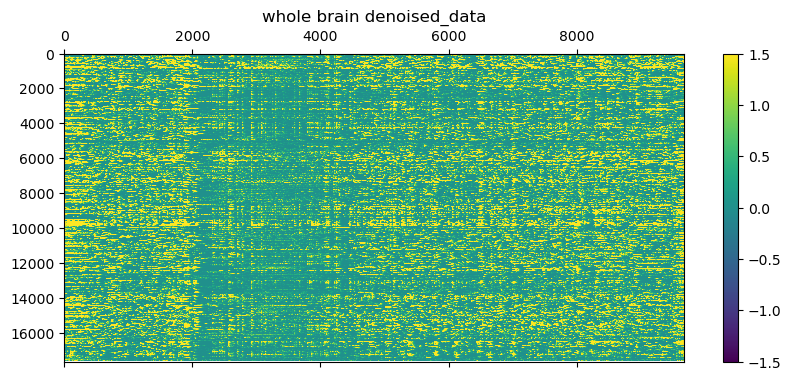

In [8]:
# calcium data
denoised_data = np.load(res_path + "neuron_denoised_records_whole_brain.npy")
print("denoised_data:", denoised_data.shape)

fig,ax = plt.subplots(figsize=(10,4), dpi=100,facecolor="w")
caxes = ax.matshow(denoised_data, vmin = -1.5, vmax = 1.5, cmap = "viridis", aspect = "auto")
fig.colorbar(caxes)
plt.title("whole brain denoised_data")
plt.show()

ele_rec_bs: <class 'numpy.ndarray'> (64, 172211)
ele_fp26: 172211


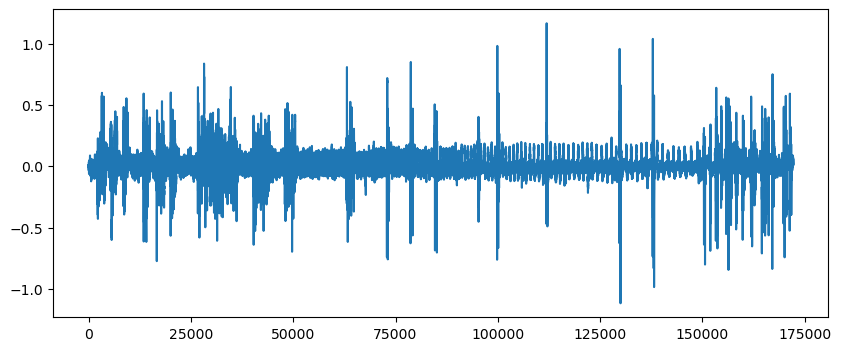

ele_rec_awake: <class 'numpy.ndarray'> (64, 151172)
ele_fp26_awake: 151172


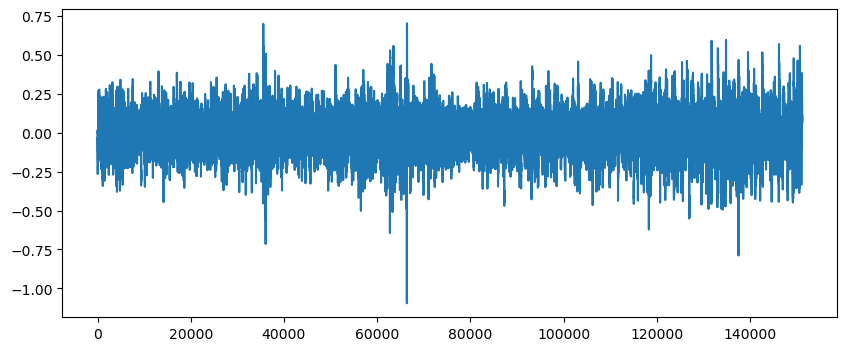

ele_rec_recovery: <class 'numpy.ndarray'> (64, 18000)
ele_fp26_recovery: 18000


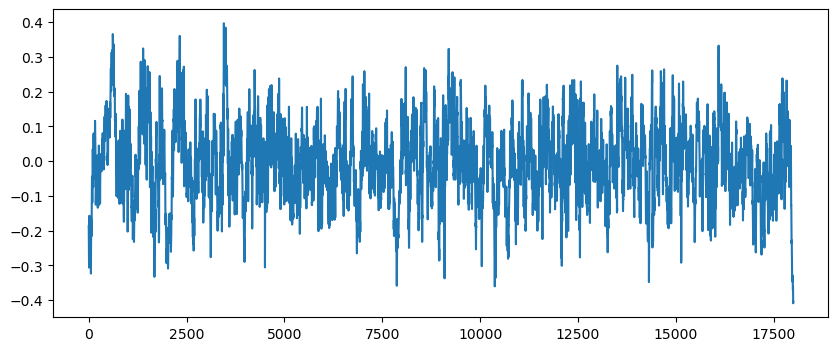

In [11]:
# ecog data
name = "burst_supp"

ele_rec_bs = pd.read_csv(load_path + "ele_signal_" + name + "_fp01-fp32.csv")
ele_rec_bs = ele_rec_bs.values
ele_rec_bs = ele_rec_bs.T
print("ele_rec_bs:", type(ele_rec_bs), ele_rec_bs.shape)

ele_fp26 = ele_rec_bs[26 * 2 - 1]
print("ele_fp26:", len(ele_fp26))
fig,ax = plt.subplots(figsize=(10,4), dpi=100,facecolor="w")
plt.plot(ele_fp26)
plt.show()


# 03 neuron selection

## 1) select neurons in burst periods

ele_start_row, ele_end_row: 2400 3400


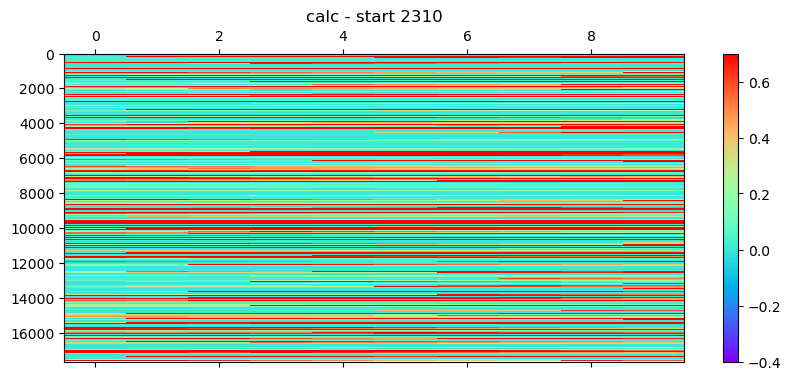

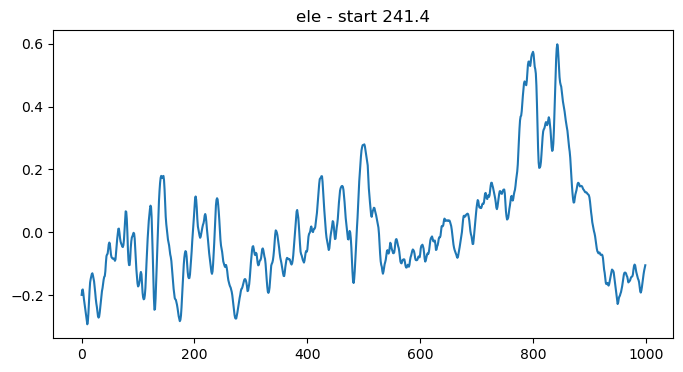

ele_start_row, ele_end_row: 5400 6400


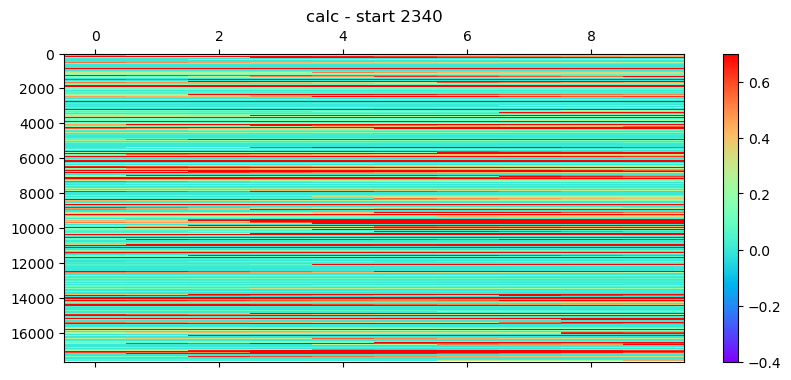

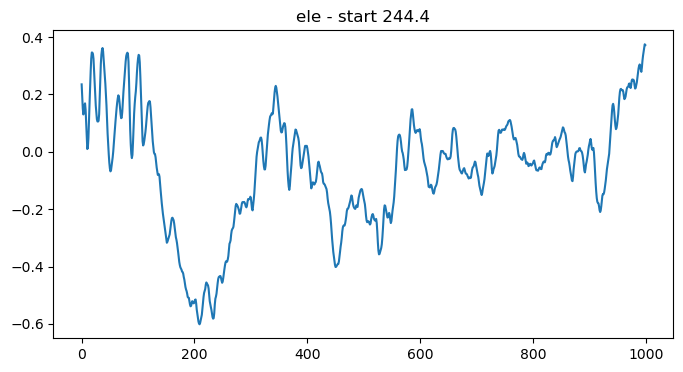

ele_start_row, ele_end_row: 8400 9400


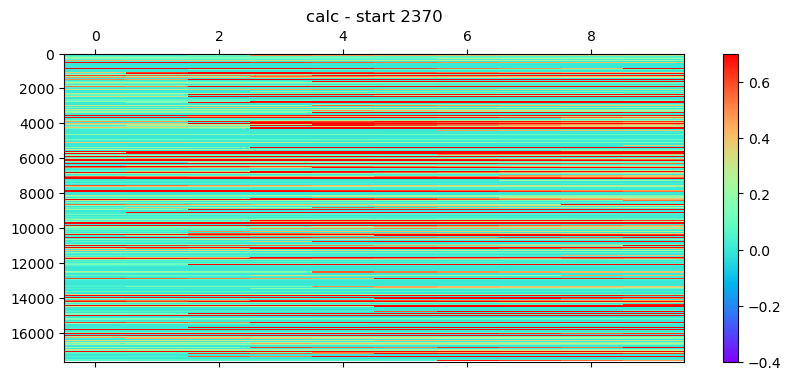

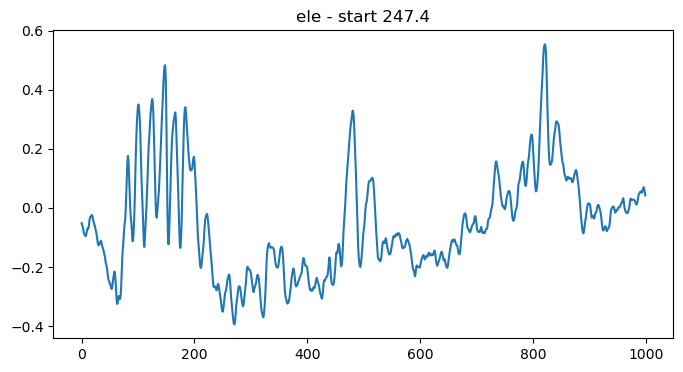

bs_select_data_ids_list: 1780
bs_select_data_ids_overlap: 50


In [13]:
'''
settings
'''
thre = 0.05
load_name = "burst_supp"
name = "burst"
ori_time = 239  # ori_time must be less than 240


'''
neuron selection
'''
select_data_ids_dict = {}
select_data_ids_list = []
select_data_ids_cnt = []
for start_id in range(len(burst_time_range)):
    calc_start = burst_time_range[start_id]
    calc_end = calc_start + duration
    ele_start, ele_end = calc_start / 10 + 10.4, calc_end / 10 + 10.4
    ele_start_row, ele_end_row = int((ele_start - ori_time) * 1000), int((ele_end - ori_time) * 1000)
    print("ele_start_row, ele_end_row:", ele_start_row, ele_end_row)

    # calcium data in the given period
    calc_rec = denoised_data[:, calc_start : calc_end]
    fig,ax = plt.subplots(figsize=(10,4), dpi=100, facecolor="w")
    caxes = ax.matshow(calc_rec, vmin = -0.4, vmax = 0.7, cmap = "rainbow", aspect = "auto")
    fig.colorbar(caxes)
    plt.title("calc - start " + str(calc_start))
    plt.show()

    # ecog data in the given period
    ele_rec = ele_fp26[ele_start_row : ele_end_row]
    fig,ax = plt.subplots(figsize=(8,4), dpi=100, facecolor="w")
    plt.plot(ele_rec)
    plt.title("ecog - start " + str(ele_start))
    plt.show()
    
    # comparison and selection
    select_data_ids = []
    for i in range(len(denoised_data)):
        # slicing
        data_i = denoised_data[i]
        neuron_avg = np.mean(data_i) # average value
        curr_part = data_i[calc_start : calc_end] # current part
        curr_awake = data_i[awake_start : awake_end] # awake part
        curr_recovery = data_i[recovery_start : recovery_end] # recivery part
        
        # compring
        stat, p_value1 = stats.mannwhitneyu(curr_part, curr_awake, alternative='two-sided')
        stat, p_value2 = stats.mannwhitneyu(curr_part, curr_recovery, alternative='two-sided')
        stat, p_value3 = stats.mannwhitneyu(curr_part, [neuron_avg] * len(curr_part), alternative='two-sided')
        if p_value1 < thre and np.mean(curr_part) > np.mean(curr_awake) \
            and p_value2 < thre and np.mean(curr_part) > np.mean(curr_recovery) \
            and p_value3 < thre and np.mean(curr_part) > neuron_avg:
            select_data_ids.append(i)
                    
    # results collection
    select_data_ids_dict[calc_start] = select_data_ids
    select_data_ids_list.extend(select_data_ids)
    select_data_ids_cnt.append(len(select_data_ids))
        
select_data_ids_list = list(set(select_data_ids_list))
print("select_data_ids_list:", len(select_data_ids_list))


'''
saving
'''
select_data_ids_overlap = []
cnt = 0
for calc_start in burst_time_range:  
    np.save(res_path + "neurons/neurons_ids_" + name + "_start" + str(calc_start) + "_duration" + str(duration) + "_selfAvg.npy", select_data_ids_dict[calc_start])
    if cnt == 0:
        select_data_ids_overlap = select_data_ids_dict[calc_start]
        cnt += 1
    else:
        overlap = [i for i in select_data_ids_overlap if i in select_data_ids_dict[calc_start]]
        select_data_ids_overlap = overlap if len(overlap) > 0 else select_data_ids_dict[calc_start]
print("select_data_ids_overlap:", len(select_data_ids_overlap))
        
np.save(res_path + "neurons/neurons_ids_" + name + "_all_start_overlap_selfAvg_relax.npy", select_data_ids_overlap)
np.save(res_path + "neurons/neurons_ids_" + name + "_all_start_set_selfAvg_relax.npy", select_data_ids_list)
np.save(res_path + "neurons/neurons_ids_" + name + "_all_start_cnt_selfAvg_relax.npy", select_data_ids_cnt)

## 2) select neurons in suppression periods

ele_start_row, ele_end_row: 1000 2000


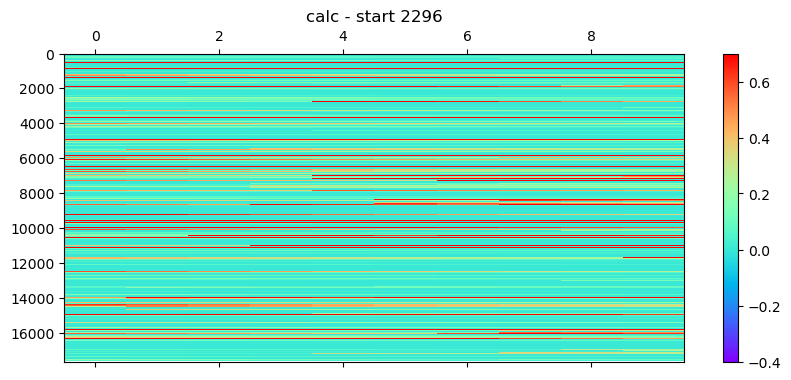

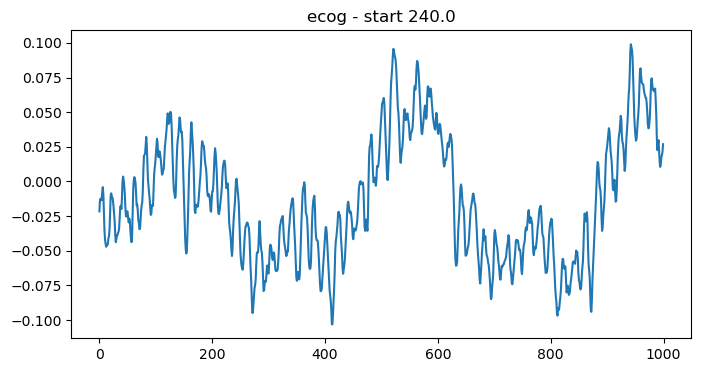

ele_start_row, ele_end_row: 4400 5400


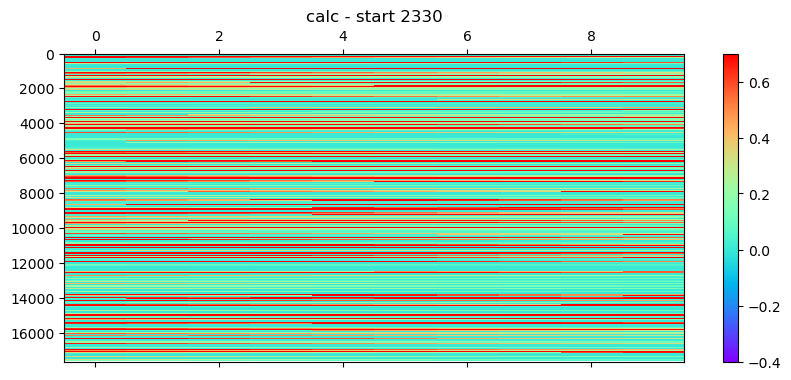

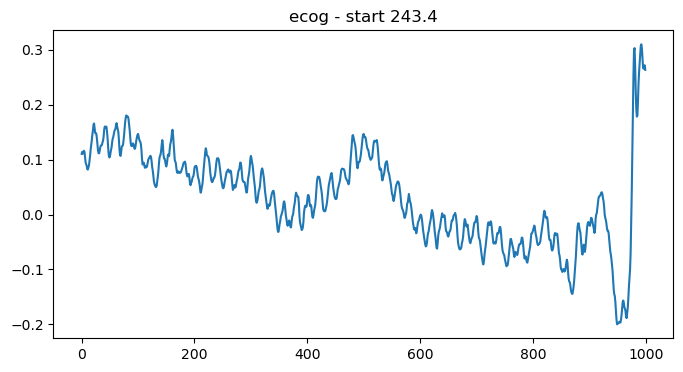

select_data_ids_list: 931
select_data_ids_overlap: 55


In [14]:
'''
settings
'''
thre = 0.05
load_name = "burst_supp"
name = "supp"
ori_time = 239  # ori_time must be less than 240

'''
neuron selection
'''
select_data_ids_dict = {}
select_data_ids_list = []
select_data_ids_cnt = []
for start_id in range(len(supp_time_range)):
    calc_start = supp_time_range[start_id]
    calc_end = calc_start + duration
    ele_start, ele_end = calc_start / 10 + 10.4, calc_end / 10 + 10.4
    ele_start_row, ele_end_row = int((ele_start - ori_time) * 1000), int((ele_end - ori_time) * 1000)
    print("ele_start_row, ele_end_row:", ele_start_row, ele_end_row)

    # calcium data in the given period
    calc_rec = denoised_data[:, calc_start : calc_end]
    fig,ax = plt.subplots(figsize=(10,4), dpi=100, facecolor="w")
    caxes = ax.matshow(calc_rec, vmin = -0.4, vmax = 0.7, cmap = "rainbow", aspect = "auto")
    fig.colorbar(caxes)
    plt.title("calc - start " + str(calc_start))
    plt.show()

    # ecog data in the given period
    ele_rec = ele_fp26[ele_start_row : ele_end_row]
    fig,ax = plt.subplots(figsize=(8,4), dpi=100, facecolor="w")
    plt.plot(ele_rec)
    plt.title("ecog - start " + str(ele_start))
    plt.show()
    
    # comparison and selection
    select_data_ids = []
    for i in range(len(denoised_data)):
        # slicing
        data_i = denoised_data[i]
        neuron_avg = np.mean(data_i) # average value
        curr_part = data_i[calc_start : calc_end] # current part
        curr_awake = data_i[awake_start : awake_end] # awake part
        curr_recovery = data_i[recovery_start : recovery_end] # recivery part
        
        # compring
        stat, p_value1 = stats.mannwhitneyu(curr_part, curr_awake, alternative='two-sided')
        stat, p_value2 = stats.mannwhitneyu(curr_part, curr_recovery, alternative='two-sided')
        stat, p_value3 = stats.mannwhitneyu(curr_part, [neuron_avg] * len(curr_part), alternative='two-sided')
        if p_value1 < thre and np.mean(curr_part) > np.mean(curr_awake) \
            and p_value2 < thre and np.mean(curr_part) > np.mean(curr_recovery) \
            and p_value3 < thre and np.mean(curr_part) > neuron_avg:
            select_data_ids.append(i)
                    
    # results collection
    select_data_ids_dict[calc_start] = select_data_ids
    select_data_ids_list.extend(select_data_ids)
    select_data_ids_cnt.append(len(select_data_ids))
        
select_data_ids_list = list(set(select_data_ids_list))
print("select_data_ids_list:", len(select_data_ids_list))


'''
saving
'''
select_data_ids_overlap = []
cnt = 0
for calc_start in supp_time_range:  
    np.save(res_path + "neurons/neurons_ids_" + name + "_start" + str(calc_start) + "_duration" + str(duration) + "_selfAvg.npy", select_data_ids_dict[calc_start])
    if cnt == 0:
        select_data_ids_overlap = select_data_ids_dict[calc_start]
        cnt += 1
    else:
        overlap = [i for i in select_data_ids_overlap if i in select_data_ids_dict[calc_start]]
        select_data_ids_overlap = overlap if len(overlap) > 0 else select_data_ids_dict[calc_start]
print("select_data_ids_overlap:", len(select_data_ids_overlap))
        
np.save(res_path + "neurons/neurons_ids_" + name + "_all_start_overlap_selfAvg_relax.npy", select_data_ids_overlap)
np.save(res_path + "neurons/neurons_ids_" + name + "_all_start_set_selfAvg_relax.npy", select_data_ids_list)
np.save(res_path + "neurons/neurons_ids_" + name + "_all_start_cnt_selfAvg_relax.npy", select_data_ids_cnt)

# 04 neuron classification

## 1) burst neurons

In [22]:
'''
settings
'''
name = "burst"

# timeline 
burst_supp_time_range = burst_time_range + supp_time_range
burst_supp_time_range.sort()
print("burst_supp_time_range:", len(burst_supp_time_range))

burst_time_idx = []
for i in burst_time_range:
    burst_time_idx.append(burst_supp_time_range.index(i))
supp_time_idx = []
for i in supp_time_range:
    supp_time_idx.append(burst_supp_time_range.index(i))
print("burst_time_idx:", len(burst_time_idx), "supp_time_idx:", len(supp_time_idx))

# load data
select_data_ids = np.load(res_path + "neurons/neurons_ids_" + name + "_all_start_set_selfAvg_relax.npy")
print("select_data_ids:", len(select_data_ids), type(select_data_ids))

select_data_ids_dict = {}
for start in burst_supp_time_range:   
    if start in burst_time_range:
        select_data_ids_dict[start] = np.load(res_path + "neurons/neurons_ids_burst_start" + str(start) + "_duration" + str(duration) + "_selfAvg_relax.npy")
    else:
        select_data_ids_dict[start] = np.load(res_path + "neurons/neurons_ids_supp_start" + str(start) + "_duration" + str(duration) + "_selfAvg_relax.npy")

# sort neurons
code_list = []
count_0 = 0
for neuron_i in select_data_ids:
    code = []
    for start in burst_supp_time_range:
        if neuron_i in select_data_ids_dict[start]:
            code.append(1)
        else:
            code.append(0)
    code_int = ''.join(str(i) for i in code)
    code_list.append(int(code_int))
    if int(code_int) == 0:
        count_0 += 1

sort_id = sorted(range(len(code_list)), key = lambda k: code_list[k], reverse = True)
sort_id = sort_id[0 : len(sort_id) - count_0]
select_data_ids_sort = [select_data_ids[i] for i in sort_id]
print("select_data_ids_sort:", len(select_data_ids_sort))

# obtain neuron codes
num = len(burst_supp_time_range)
code_matrix = np.zeros((len(sort_id), num))
for i in range(len(sort_id)):
    code = code_list[sort_id[i]]
    code_int_list = [int(j) for j in list(str(code))]
    for k in range(len(code_int_list)):
        int_idx = len(code_int_list) - k - 1
        matrix_idx = num - k - 1
        code_matrix[i,matrix_idx] = code_int_list[int_idx] 

# classification
only_burst_ids = []
burst_and_supp_ids = []
for i in range(len(code_matrix)):
    active_idx = list(np.where(code_matrix[i] == 1)[0])
    supp_active_idx = list(set(active_idx) & set(supp_time_idx))
    burst_active_idx = list(set(active_idx) & set(burst_time_idx))
    if len(burst_active_idx) == 0:
        continue
    if len(supp_active_idx) == 0:
        only_burst_ids.append(i)
    else:
        burst_and_supp_ids.append(i)

# saving
only_burst_ids_real = [select_data_ids_sort[i] for i in only_burst_ids]
print("only_burst_ids_real:", len(only_burst_ids_real)) 
np.save(res_path + "neurons_only_burst_ids.npy", only_burst_ids_real)

burst_and_supp_ids_real = [select_data_ids_sort[i] for i in burst_and_supp_ids]
print("burst_and_supp_ids_real:", len(burst_and_supp_ids_real)) 
np.save(res_path + "neurons_both_burst_supp_ids.npy", burst_and_supp_ids_real)


burst_supp_time_range: 38
burst_time_idx: 19 supp_time_idx: 19
select_data_ids: 13135 <class 'numpy.ndarray'>
select_data_ids_sort: 13096
only_burst_ids_real: 7432
burst_and_supp_ids_real: 5596


## 2) suppresion neurons

In [23]:
'''
settings
'''
name = "supp"

# timeline 
burst_supp_time_range = burst_time_range + supp_time_range
burst_supp_time_range.sort()
print("burst_supp_time_range:", len(burst_supp_time_range))

burst_time_idx = []
for i in burst_time_range:
    burst_time_idx.append(burst_supp_time_range.index(i))
supp_time_idx = []
for i in supp_time_range:
    supp_time_idx.append(burst_supp_time_range.index(i))
print("burst_time_idx:", len(burst_time_idx), "supp_time_idx:", len(supp_time_idx))

# load data
select_data_ids = np.load(res_path + "neurons/neurons_ids_" + name + "_all_start_set_selfAvg_relax.npy")
print("select_data_ids:", len(select_data_ids), type(select_data_ids))

select_data_ids_dict = {}
for start in burst_supp_time_range:   
    if start in burst_time_range:
        select_data_ids_dict[start] = np.load(res_path + "neurons/neurons_ids_burst_start" + str(start) + "_duration" + str(duration) + "_selfAvg_relax.npy")
    else:
        select_data_ids_dict[start] = np.load(res_path + "neurons/neurons_ids_supp_start" + str(start) + "_duration" + str(duration) + "_selfAvg_relax.npy")

# sort neurons
code_list = []
count_0 = 0
for neuron_i in select_data_ids:
    code = []
    for start in burst_supp_time_range:
        if neuron_i in select_data_ids_dict[start]:
            code.append(1)
        else:
            code.append(0)
    code_int = ''.join(str(i) for i in code)
    code_list.append(int(code_int))
    if int(code_int) == 0:
        count_0 += 1

sort_id = sorted(range(len(code_list)), key = lambda k: code_list[k], reverse = True)
sort_id = sort_id[0 : len(sort_id) - count_0]
select_data_ids_sort = [select_data_ids[i] for i in sort_id]
print("select_data_ids_sort:", len(select_data_ids_sort))

# obtain neuron codes
num = len(burst_supp_time_range)
code_matrix = np.zeros((len(sort_id), num))
for i in range(len(sort_id)):
    code = code_list[sort_id[i]]
    code_int_list = [int(j) for j in list(str(code))]
    for k in range(len(code_int_list)):
        int_idx = len(code_int_list) - k - 1
        matrix_idx = num - k - 1
        code_matrix[i,matrix_idx] = code_int_list[int_idx] 

# classification
only_supp_ids = []
burst_and_supp_ids = []
for i in range(len(code_matrix)):
    active_idx = list(np.where(code_matrix[i] == 1)[0])
    supp_active_idx = list(set(active_idx) & set(supp_time_idx))
    burst_active_idx = list(set(active_idx) & set(burst_time_idx))
    if len(supp_active_idx) == 0:
        continue
    if len(burst_active_idx) == 0:
        only_supp_ids.append(i)
    else:
        burst_and_supp_ids.append(i)

# saving
only_supp_ids_real = [select_data_ids_sort[i] for i in only_supp_ids]
print("only_supp_ids_real:", len(only_supp_ids_real)) 
np.save(res_path + "neurons_only_supp_ids.npy", only_supp_ids_real)

burst_and_supp_ids_real = [select_data_ids_sort[i] for i in burst_and_supp_ids]
print("burst_and_supp_ids_real:", len(burst_and_supp_ids_real)) 
np.save(res_path + "neurons_both_burst_supp_ids.npy", burst_and_supp_ids_real)


burst_supp_time_range: 38
burst_time_idx: 19 supp_time_idx: 19
select_data_ids: 7641 <class 'numpy.ndarray'>
select_data_ids_sort: 7596
only_supp_ids_real: 1270
burst_and_supp_ids_real: 5596


# 05 comparison figure

burst_select_data_ids: 7432
supp_select_data_ids: 1270
both_select_data_ids: 5596
only_burst VS only_supp -- stat, p_value: 359.0 1.0129277545479352e-07
only_burst VS both_burst_supp -- stat, p_value: 468.0 0.03570423172893923
both_burst_supp VS only_supp -- stat, p_value: 716.0 9.793026239685932e-10


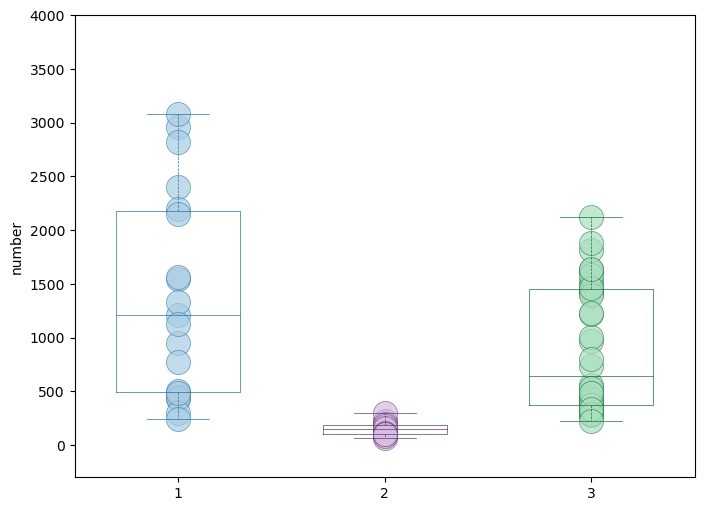

In [26]:
# load data
burst_select_data_ids = np.load(res_path + "neurons_only_burst_ids.npy").tolist()
print("burst_select_data_ids:", len(burst_select_data_ids))

supp_select_data_ids = np.load(res_path + "neurons_only_supp_ids.npy").tolist()
print("supp_select_data_ids:", len(supp_select_data_ids))

both_select_data_ids = np.load(res_path + "neurons_both_burst_supp_ids.npy").tolist()
print("both_select_data_ids:", len(both_select_data_ids))

# calculate neuron number
only_burst_neuron_num = [0] * len(burst_time_range)
only_supp_neuron_num = [0] * len(supp_time_range)
both_burst_neuron_num = [0] * len(burst_time_range)
both_supp_neuron_num = [0] * len(supp_time_range)
both_burst_supp_neuron_num = [0] * len(burst_supp_time_range) 

for i in range(len(burst_time_range)): 
    start = burst_time_range[i]
    select_data_ids = np.load(res_path + "neurons/neurons_ids_burst_start" + str(start) + "_duration" + str(duration) + "_selfAvg_relax.npy")
    
    for j in select_data_ids:
        if j in burst_select_data_ids:
            only_burst_neuron_num[i] += 1
        elif j in both_select_data_ids:
            both_burst_neuron_num[i] += 1
            
for i in range(len(supp_time_range)): 
    start = supp_time_range[i]
    select_data_ids = np.load(res_path + "neurons/neurons_ids_supp_start" + str(start) + "_duration" + str(duration) + "_selfAvg_relax.npy")
    
    for j in select_data_ids:
        if j in supp_select_data_ids:
            only_supp_neuron_num[i] += 1
        elif j in both_select_data_ids:
            both_supp_neuron_num[i] += 1            

for i in range(len(burst_time_range)):
    idx = burst_time_idx[i]
    both_burst_supp_neuron_num[idx] = both_burst_neuron_num[i]
    idx = supp_time_idx[i]
    both_burst_supp_neuron_num[idx] = both_supp_neuron_num[i]
          
        
'''
test
'''
stat, p_value = stats.mannwhitneyu(only_burst_neuron_num, only_supp_neuron_num, alternative='greater')
print("only_burst VS only_supp -- stat, p_value:", stat, p_value)

stat, p_value = stats.mannwhitneyu(only_burst_neuron_num, both_burst_supp_neuron_num, alternative='greater')
print("only_burst VS both_burst_supp -- stat, p_value:", stat, p_value)

stat, p_value = stats.mannwhitneyu(both_burst_supp_neuron_num, only_supp_neuron_num, alternative='greater')
print("both_burst_supp VS only_supp -- stat, p_value:", stat, p_value)


'''
plot
'''
y_list = [only_burst_neuron_num, only_supp_neuron_num, both_burst_supp_neuron_num]

fig,ax = plt.subplots(figsize=(8,6), dpi=100,facecolor="w")
bplot = ax.boxplot(y_list, vert=True, widths = 0.6)

# box line
colors = ['#2471A3', '#633974', '#196F3D']
for box, color in zip(bplot['boxes'], colors):
    box.set(color = color, linewidth = 0.5)
    
# middle line
for median, color in zip(bplot['medians'], colors):
    median.set(color = color, linewidth = 0.5)
    
# verticle line
cnt = 0
for whisker, cap in zip(bplot['whiskers'], bplot['caps']):
    if cnt in [0,1]:
        color = colors[0]
        cnt += 1
    elif cnt in [2,3]:
        color = colors[1]
        cnt += 1
    else:
        color = colors[2]
        cnt += 1
    whisker.set(color = color, linestyle = "--", linewidth = 0.5)
    cap.set(color = color, linewidth = 0.5)
       
plt.scatter([1]*len(only_burst_neuron_num), only_burst_neuron_num, color = '#A9CCE3', edgecolor = '#2471A3', \
            s = 300, linewidth = 0.5, alpha =0.7)
plt.scatter([2]*len(only_supp_neuron_num), only_supp_neuron_num, color = '#D7BDE2', edgecolor = '#633974', \
            s = 300, linewidth = 0.5, alpha =0.7)
plt.scatter([3]*len(both_burst_supp_neuron_num), both_burst_supp_neuron_num, color = '#A9DFBF', edgecolor = '#196F3D', \
            s = 300, linewidth = 0.5, alpha =0.7)

ax.set_ylabel("number")
plt.ylim(-300, 4000)
# plt.savefig(res_path + "neurons_3type-bs-ane_numbers_compare.png", bbox_inches='tight')
# plt.savefig(res_path + "neurons_3type-bs-ane_numbers_compare.pdf", bbox_inches='tight')
plt.show()